In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.applications.vgg16 import preprocess_input as pi
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install segmentation_models
# !export SM_FRAMEWORK=tf.keras
# %env SM_FRAMEWORK=tf.keras


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import glob
import cv2
import os
images_t = glob.glob("/kaggle/input/eye-data/train/*.jpeg")
labels_t=pd.read_csv('/kaggle/input/trainlabelcsv/trainLabels.csv')

temp=np.array(labels_t[labels_t.level==4].image.values)
level_4=[]
for i in temp:
    if '/kaggle/input/eye-data/train/'+i+'.jpeg' in images_t:
        level_4.append(i)
level_4=np.array(level_4)
np.random.shuffle(level_4)
# level_4=level_4[:300]

temp=np.array(labels_t[labels_t.level==3].image.values)
level_3=[]
for i in temp:
    if '/kaggle/input/eye-data/train/'+i+'.jpeg' in images_t:
        level_3.append(i)
level_3=np.array(level_3)
np.random.shuffle(level_3)
# level_3=level_3[:300]

temp=np.array(labels_t[labels_t.level==2].image.values)
level_2=[]
for i in temp:
    if '/kaggle/input/eye-data/train/'+i+'.jpeg' in images_t:
        level_2.append(i)
level_2=np.array(level_2)
np.random.shuffle(level_2)
# level_2=level_2[:300]

temp=np.array(labels_t[labels_t.level==1].image.values)
level_1=[]
for i in temp:
    if '/kaggle/input/eye-data/train/'+i+'.jpeg' in images_t:
        level_1.append(i)
level_1=np.array(level_1)
np.random.shuffle(level_1)
# level_1=level_1[:300]

temp=np.array(labels_t[labels_t.level==0].image.values)
level_0=[]
for i in temp:
    if '/kaggle/input/eye-data/train/'+i+'.jpeg' in images_t:
        level_0.append(i)
level_0=np.array(level_0)
np.random.shuffle(level_0)
# level_0=level_0[:300]

imgs=np.concatenate((level_0,level_1,level_2,level_3,level_4),axis=0)
images_t=[]
for i in range(imgs.shape[0]):
    images_t.append('/kaggle/input/eye-data/train/'+str(imgs[i])+'.jpeg')

In [8]:
print(level_0.shape)
print(level_1.shape)
print(level_2.shape)
print(level_3.shape)
print(level_4.shape)

(6150,)
(588,)
(1283,)
(221,)
(166,)


In [9]:
img_h=128
img_w=128

train_img=np.zeros((len(images_t),img_h,img_w,3),dtype='float32')
train_label=np.zeros((len(images_t)))
labs_=[level_0.shape[0],level_1.shape[0],level_2.shape[0],level_3.shape[0],level_4.shape[0]]
labs_[1]+=labs_[0]
labs_[2]+=labs_[1]
labs_[3]+=labs_[2]
labs_[4]+=labs_[3]
labs_

[6150, 6738, 8021, 8242, 8408]

In [10]:
n=0
lab=0
for i,id in tqdm(enumerate(images_t),total=len(images_t)):
  if(i in labs_):
    lab+=1
  # if limit[(labels_t[(labels_t.image==name)])['level'].values[0]]>=220:
  #   continue
  # limit[(labels_t[(labels_t.image==name)])['level'].values[0]]+=1
  img=load_img(id,target_size=(img_h,img_w))
  img=img_to_array(img)
  train_img[n]=img
  train_label[n]=lab
  n+=1
  # train_label[i][(labels_t[(labels_t.image==name)])['level'].values[0]]=(labels_t[(labels_t.image==name)])['level'].values[0]

100%|██████████| 8408/8408 [11:11<00:00, 12.53it/s]


In [11]:
limit={
    0:0,
    1:0,
    2:0,
    3:0,
    4:0
}
limit[0]=len(np.where(train_label==0)[0])
limit[1]=len(np.where(train_label==1)[0])
limit[2]=len(np.where(train_label==2)[0])
limit[3]=len(np.where(train_label==3)[0])
limit[4]=len(np.where(train_label==4)[0])
limit

{0: 6150, 1: 588, 2: 1283, 3: 221, 4: 166}

(array([6150.,    0.,  588.,    0.,    0., 1283.,    0.,  221.,    0.,
         166.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

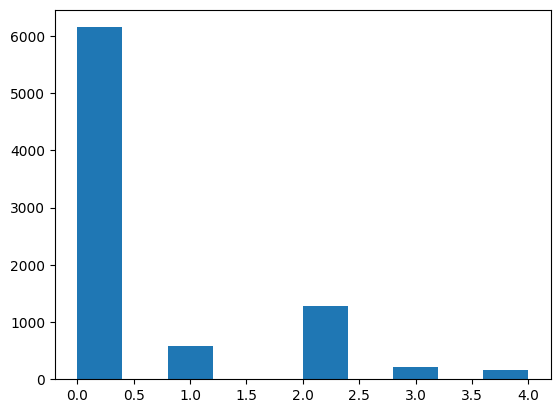

In [12]:
plt.hist(train_label)

In [32]:
# SPLITTING DATA BEFORE AUGMENTATION
from sklearn.model_selection import train_test_split
N=train_img.shape[0]
idx = np.arange(N)
np.random.shuffle(idx)
train_img=train_img[idx]
train_label=train_label[idx]

x_train, x_test, y_train, y_test = train_test_split(train_img, train_label, test_size = 0.1, random_state = 42)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
limit[0]=len(np.where(y_train==0)[0])
limit[1]=len(np.where(y_train==1)[0])
limit[2]=len(np.where(y_train==2)[0])
limit[3]=len(np.where(y_train==3)[0])
limit[4]=len(np.where(y_train==4)[0])
print(limit)

(7567, 128, 128, 3)
(7567,)
(841, 128, 128, 3)
(841,)
{0: 5538, 1: 521, 2: 1148, 3: 206, 4: 154}


(array([5538.,    0.,  521.,    0.,    0., 1148.,    0.,  206.,    0.,
         154.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

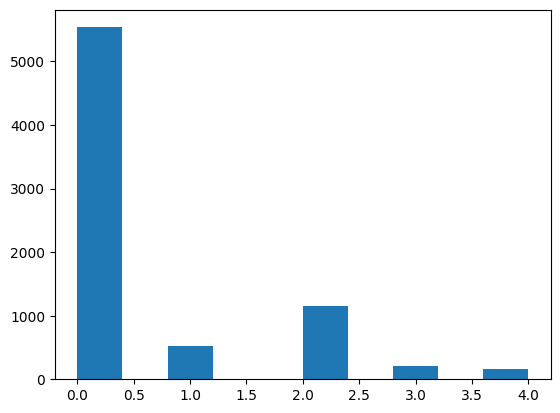

In [33]:
plt.hist(y_train)

In [34]:
#NORMALIZATION
from keras.utils import to_categorical
y_train=to_categorical(y_train, 5)
y_test=to_categorical(y_test, 5)
# x_train = (x_train*1.0)/255.0
# x_test=(x_test*1.0)/255.0

In [35]:
N=x_train.shape[0]
BATCH_SIZE=32
idx = np.arange(N)
np.random.shuffle(idx)
data_train = (tf.data.Dataset.from_tensor_slices((x_train[idx],y_train[idx])).batch(BATCH_SIZE,drop_remainder=True))
data_test=(tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(BATCH_SIZE,drop_remainder=True))


In [36]:
from keras import backend as K
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [41]:
def create_model(input_shape, n_out):
    pretrain_model = PTModel(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        classifier_activation='softmax',
    )
    pretrain_model.trainable=False
    input_tensor = Input(input_shape)
#     c0 = BatchNormalization()(input_tensor)
    c1= pretrain_model(input_tensor)
#     c1=GlobalAveragePooling2D()(c1)
    preproc=tf.keras.applications.inception_resnet_v2.preprocess_input(c1)
#     c1 = Conv2D(128,3, activation='relu')(c1)
#     c1 = Dropout(0.4)(c1)
#     c1 = Dropout(0.4)(c1)
    c1 = Dense(512, activation='relu')(preproc)
#     c1 = Dropout(0.4)(c1)
    c1 = Flatten()(c1)
    output = Dense(n_out, activation='softmax')(c1)
    model = Model(input_tensor, output)

    return model

In [42]:
# from tensorflow.keras.applications import InceptionResNetV2 as PTModel
# md=create_model((img_h,img_w,3),5)
# md.summary()

In [43]:
# callback params
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', patience=1, cooldown=1, verbose=1,
    factor=0.75, min_lr=1e-8)
es = EarlyStopping( monitor = 'val_loss',patience = 8,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''
checkpoint_path = "xception/cp.ckpt"

mp=ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,monitor='val_accuracy',verbose=1)
call=[es,lr_reduction]


In [44]:
from tensorflow.keras.applications import InceptionResNetV2 as PTModel

xception_model=create_model((img_h,img_w,3),5)
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss='categorical_crossentropy',metrics=['accuracy','mae',f1])
xception_model.summary()

# xception_model.load_weights(checkpoint_path)

history=xception_model.fit(
    data_train,
    validation_data=data_test,
#     validation_split=0.1,
#     batch_size=1,
    # steps_per_epoch=100,
    epochs=20,
    callbacks=call
                            )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 tf.math.truediv (TFOpLambda  (None, 2, 2, 1536)       0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 2, 2, 1536)       0         
 a)                                                              
                                                                 
 dense (Dense)               (None, 2, 2, 512)         786944    
                                                             

In [22]:
xception_model.save_weights('weights.h5')

In [45]:
history=xception_model.fit(
    data_train,
    validation_data=data_test,
#     validation_split=0.1,
#     batch_size=1,
    # steps_per_epoch=100,
    epochs=100,
    callbacks=call
                            )

Epoch 1/100
236/236 [==============================] - 13s 55ms/step - loss: 0.8724 - accuracy: 0.7316 - mae: 0.1736 - f1: 0.1950 - val_loss: 0.8513 - val_accuracy: 0.7284 - val_mae: 0.1747 - val_f1: 0.1967 - lr: 1.7798e-04
Epoch 2/100
236/236 [==============================] - ETA: 0s - loss: 0.8722 - accuracy: 0.7316 - mae: 0.1736 - f1: 0.1951
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001334838816546835.
236/236 [==============================] - 13s 53ms/step - loss: 0.8722 - accuracy: 0.7316 - mae: 0.1736 - f1: 0.1951 - val_loss: 0.8512 - val_accuracy: 0.7284 - val_mae: 0.1748 - val_f1: 0.1967 - lr: 1.7798e-04
Epoch 3/100
236/236 [==============================] - 12s 52ms/step - loss: 0.8717 - accuracy: 0.7316 - mae: 0.1736 - f1: 0.1951 - val_loss: 0.8510 - val_accuracy: 0.7284 - val_mae: 0.1750 - val_f1: 0.1968 - lr: 1.3348e-04
Epoch 4/100
236/236 [==============================] - 12s 53ms/step - loss: 0.8716 - accuracy: 0.7316 - mae: 0.1736 - f1: 0.1952 - val_loss

KeyboardInterrupt: 